In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Boundary Layer Solver

This notebook will develop a numerical method for solving the boundary layer momentum integral equation using Pohlhausen velocity profiles.

## Momentum integral equation

In the boundary layer portion of the course we derived the governing equations for a boundary layer using the concept of a velocity profile 

$$u = u_e(x) f(\eta), \quad \eta=\frac y{\delta(x)}$$

where $u_e$ is the local free stream velocity and $\delta$ is the boundary layer thickness. Note that $x$ is the distance along the wall from the leading edge and $y$ is the distance from the wall.

---
![Boundary layer profile](resources/graphics4.png)

---

Integrating the Prandtl momentum equation through the boundary layer thickness resulted in the **momentum integral equation**

$$ \frac 12 c_f = \frac{u_e'}{u_e}(\delta_1+2\delta_2)+\delta_2' $$

This equation balances the local wall friction with the change in the boundary layer profile properties. The tick mark indicates a derivative, ie $u_e'=\frac{du_e}{dx}$. 

** The goal is to use the momentum equation to determine how the boundary layer develops, predicting the friction drag and the point of separation. **

The velocity $u_e$ (and $u_e'$) is considered to be prescribed by the potential flow solution, but there are still too many unknowns. We need to choose a profile to develop this further...

##Pohlhausen profile

The Pohlhausen profile is used to describe a **laminar** velocity profile exposed to external pressure gradients. The profile is defined as

$$ \frac u {u_e} = f(\eta,\lambda) = P_F(\eta)+\lambda P_G(\eta) $$

where $\lambda$ is the *shape factor*, given by
$$ \lambda = \frac {\delta^2}\nu u_e'$$

and the profile shapes are defined by

- $ P_F = 2\eta-2\eta^3+\eta^4 $ is the flat plate profile
- $ P_G = \frac\eta 6 (1-\eta)^3 $ is the modification for pressure gradients

These can be easly defined using a set of python functions

In [2]:
import numpy

def pohlF(eta): return 2*eta-2*eta**3+eta**4
def pohlG(eta): return eta/6*(1-eta)**3

In [3]:
from matplotlib import pyplot
%matplotlib inline

def pohlPlot(lam):
    pyplot.figure(figsize=(5,5))
    pyplot.xlabel(r'$u/u_e$', fontsize=24)
    pyplot.ylabel(r'$y/\delta$', fontsize=24)
    eta = numpy.linspace(0.0,1.0,40)
    pyplot.plot(pohlF(eta)-24*pohlG(eta),eta, lw=2, label=r'$\lambda=-24$')
    pyplot.plot(pohlF(eta)-12*pohlG(eta),eta, lw=2, label=r'$\lambda=-12$')
    pyplot.plot(pohlF(eta),eta, lw=2, label=r'$\lambda=0$')
    pyplot.plot(pohlF(eta)+12*pohlG(eta),eta, lw=2, label=r'$\lambda=12$')
    pyplot.plot(pohlF(eta)+24*pohlG(eta),eta, lw=2, label=r'$\lambda=24$')
    pyplot.legend(loc='upper left', fontsize=16)

Change $\lambda$ below to see its effect on the profile shape.

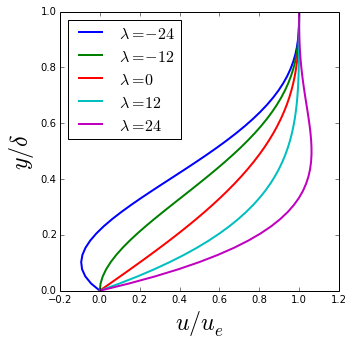

In [4]:
pohlPlot(lam=12)

##### Quiz 1

What value of $\lambda$ denotes separated flow?

1. $\lambda$<-12
1. $\lambda$=0
1. $\lambda$>12

---

Using the Pohlhausen profile, the various factors in the momentum integral equation are defined as

- $\frac{\delta_1}\delta = \int_0^1 (1-f) d\eta = \frac3{10}-\lambda\frac1{120}$


- $\frac{\delta_2}\delta = \int_0^1 f(1-f) d\eta = \frac{37}{315}-\lambda\frac1{945}-\lambda^2\frac1{9072}$


- $\frac 12 c_f Re_\delta =f'_0= 2+\lambda\frac1{6}$

where $Re_\delta = \frac{u_e\delta}\nu$ is the local boundary layer Reynolds number. 

In [5]:
def disp_ratio(lam): return 3./10.-lam/120.
def mom_ratio(lam): return 37./315.-lam/945.-lam**2/9072.
def df_0(lam): return 2+lam/6.

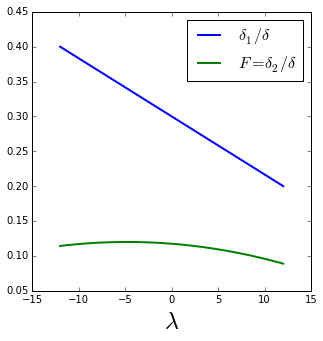

In [6]:
pyplot.figure(figsize=(5,5))
pyplot.xlabel(r'$\lambda$', fontsize=24)
lam = numpy.linspace(-12,12,100)
pyplot.plot(lam,disp_ratio(lam), lw=2, label=r'$\delta_1/\delta$')
pyplot.plot(lam,mom_ratio(lam), lw=2, label=r'$F=\delta_2/\delta$')
pyplot.legend(loc='upper right',fontsize=16)

Note that these are all polynomial functions of $\lambda$. **Since $u_e$ is given by potential flow and $\lambda = \frac {\delta^2}\nu u_e'$, the only unknown in the momentum equation is now $\delta(x)$!**

## Stagnation point condition

Now we need to write the momentum equation in terms of $\delta$ (and $\lambda$) and solve. This equation needs to be valid from the leading edge all the way to the point of separation. 

For any body with finite thickness the boundary layer will begin at the stagnation point at the front of the body. However, describing the boundary layer at a stagnation point is somewhat tricky.

![Stagnation point](resources/stagnation.png)

##### Quiz 2

Which relationships are true at a stagnation point?

1. $u_e = 0$
1. $u_e' = 0$
1. $\delta/x << 1$
1. $c_f$ is singular

---

That's no good - the momentum equation will be singular at the leading edge.  We can avoid this problem by multiplying the whole equation by $Re_\delta$, leading to:

$$ \frac 12 c_f Re_\delta = \frac\delta\nu u_e' [\delta_1+2\delta_2]+Re_\delta \delta_2'$$ 

The first term on the RHS can be simplified by dividing the brackets by $\delta$ and mutiplying by $\delta$ outside out to produce the definition of $\lambda$. This lets us group the terms only dependant on $\lambda$ together to define

$$ g_1(\lambda) = \frac 12 c_f Re_\delta - \lambda \left[\frac{\delta_1}{\delta}+2\frac{\delta_2}\delta\right]$$

In [7]:
def g_1(lam): return df_0(lam)-lam*(disp_ratio(lam)+2*mom_ratio(lam))

Using this definition, the momentum equation is

$$ g_1(\lambda) = Re_\delta \delta_2'$$ 


##### Quiz 3

The equation above further simplifies at the stagnation point. Which is correct?

1. $g_1 = 0$
1. $g_1 = Re_\delta$
1. $ \frac 12 c_f = 0$

---

Solving this equations will determine our *initial condition* $\lambda_0$. Using my vast [google skills](http://lmgtfy.com/?q=numpy+find+root&l=1) I found the `bisect` function in `scipy.optimize` which will solve for the root.

In [8]:
from scipy.optimize import bisect
lam0 = bisect(g_1,-12,12)
print('lambda_0 = '+'%.3f'%lam0)

lambda_0 = 7.052


With the value of $\lambda_0$ determined, the initial condition $\delta_0$ is simply

$$ \delta_0 = \sqrt{\frac{\nu \lambda_0}{u_e'(x_0)}} $$

## Pohlhausen evolution equation

The only thing left to do is write $\delta_2'$ in terms of $\delta'$. Using $F=\frac{\delta_2}\delta$ we have

$$ \delta_2' = \frac{d}{dx}(F\delta) $$

From the line plot above, we see that $F$ is nearly unchanged across the whole range of $\lambda$, so we will treat it as a constant. Therefore the complete Pohlhausen momentum equation is

$$ g_1 = Re_\delta F \delta'$$

Isolating the derivative, we have

$$ \delta'= \frac{g_1(\lambda)}{Re_\delta F(\lambda)} $$

In [9]:
def ddx_delta(Re_d,lam):
    if Re_d==0: return 0                     # Stagnation point condition
    return g_1(lam)/mom_ratio(lam)/Re_d      # delta'

Lets plot the functions of  $\lambda$ to get a feel for how the boundary layer will develop.

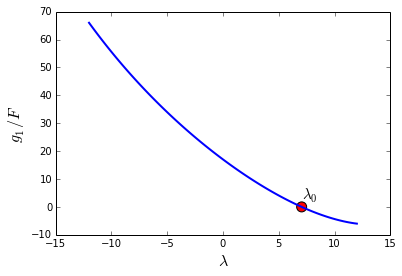

In [10]:
pyplot.xlabel(r'$\lambda$', fontsize=16)
pyplot.ylabel(r'$g_1/F$', fontsize=16)
pyplot.plot(lam,ddx_delta(1,lam), lw=2)
pyplot.scatter(lam0,0, s=100, c='r')
pyplot.text(lam0,3, r'$\lambda_0$',fontsize=15)

##### Quiz 4

What will happen if $\lambda>\lambda_0$?

1. Flat plate boundary layer flow.
1. The boundary layer will shrink.
1. The Pohlausen equation will be singular.

## Ordinary differential equations

The $\delta$ evolution equation above is an ordinary differentilal equation (ODE), having the form

$$ \delta' = g(\delta(x),x) $$

where the derivative is only a function of the variable and one indepentant variable $x$. All ODEs have an important feature in common:

##### Mathematics fundamental: ODEs
##### Systems' whose evolution depends only on their current state 

This makes them easier to solve. If we integrate the ODE from $x_0$ to $x_1$ we have

$$ \delta(x_1) = \delta_1= \delta_0+\int_{x_0}^{x_1} g(\delta(x),x) dx $$

which means all we need to solve for $\delta_1$ is the initial condition $\delta_0$ and an estimate the RHS integral. And once we have $\delta_1$, we can get $\delta_2$, etc. In general we have

$$ \delta_{i+1}= \delta_i+\int_{x_i}^{x_{i+1}} g(\delta(x),x) dx  \quad i=0,\ldots, N-1$$

This means the ODE can be solved by *marching* from $x=0$ to $x=L$. Compare this to the vortex panel method and its linear system of equations that needed to be solved simultaneously using matrices... This is easy.

## Boundary layer module

I have implemented a function `march` to solve the boundary layer ODE defined by `ddx_delta` above. It is found in the BoundaryLayer.py file. Let's import it and look at the `help`:

In [11]:
from BoundaryLayer import march
help(march)

Help on function march in module BoundaryLayer:

march(x, u_e, nu)
    # march along boundary layer from stagnation to separation:
    # return the boundary layer thickness, shape function,
    # and separation index



The inputs to the function are:

 - `x`=$x$, an array holding the distance along the boundary layer,
 - `u_e`=$u_e(x)$, an array holding the external velocity at each $x$, and
 - `nu`=$\nu$, the kinematic viscosity.
 
The function breaks out of the marching loop if the flow separates ($\lambda<-12$) and returns:
 - the array index `i` at which the flow separates,
 - `delta`=$\delta(x)$, the array holding the boundary layer thickness, and
 - `lam`=$\lambda(x)$, the shape function. 
 
A few notes:

- The initial condition for the formulation above must be a stagnation point. Therefore, if `u_e[0]>0` (not a stagnation point) then `march` assumes the stagnation point is at $x=0$ and integrates from $x=0\ldots$`x[0]`. If you pass `x[0]=0` and `u_e[0]>0` then the function will fail.

-  The output arrays are undefined after `i`. In other words, the value `delta[i+1]` is meaningless.

---



##### Your turn #5

Use flat plate theory to test the `march` function:

- ** Define ** the inputs to `march` for a flat plate with $L=1$, $U_\infty=1$, and $Re_L=10^5$.
- ** Plot and compare ** the boundary layer thickness againt the analytic Pohlhausen flat plate solution 
$$\frac\delta L=\frac{5.836}{\sqrt{Re_x}}\frac xL$$
- ** Write ** $\tau_w/\rho$ as a function of $u_e$, $\delta$, $\lambda$ and $\nu$.
- ** Complete ** the $c_f$ function for the local fiction coefficient 
- ** Plot and compare ** the friction coefficint against the analytic Pohlhausen flat plate solution
$$c_f=\frac{6.85}{\sqrt{Re_x}}$$
- ** Complete ** the $C_F$ function for the integrated friction coefficient
$$C_F = \frac{D}{\tfrac 12 \rho U_\infty^2 L } = \frac{\int_0^L \tau_w dx}{\tfrac 12 \rho U_\infty^2 L }$$
where 
$$ \tau_w = \frac 12 c_f \rho u_e^2 $$
Do not assume $u_e=U_\infty$ is a constant. 
- **Compare** the function output to the flat plate analytic solution 
$$C_F = 1.33/\sqrt{Re_L}$$

##### Solution #5

Set up and run `march`:

In [12]:
N=32
x = numpy.linspace(0,1,N)
nu = 1e-5 # double check !!
#u_e = ??

#delta,lam,iSep = march(x,u_e,nu)       # solve!

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


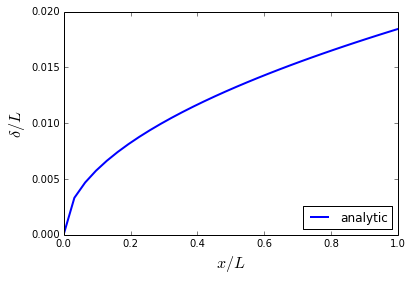

In [13]:
pyplot.ylabel(r'$\delta/L$', fontsize=16)
pyplot.xlabel(r'$x/L$', fontsize=16)
pyplot.legend(loc='upper left')

pyplot.plot(x,5.836*numpy.sqrt(nu*x),lw=2,label='analytic')
# your code here
pyplot.legend(loc='lower right')

Get the local and integrated stress.

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


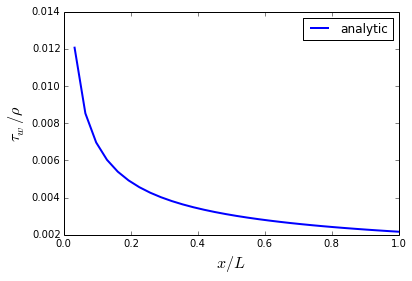

In [14]:
def c_f(u_e,delta,lam,nu):
    # your code here
    return c_f

pyplot.ylabel(r'$\tau_w/\rho$', fontsize=16)
pyplot.xlabel(r'$x/L$', fontsize=16)

pyplot.plot(x,0.685*numpy.sqrt(nu/x),lw=2,label='analytic')
# your code here
pyplot.legend(loc='upper right')

In [15]:
def C_F(u_e,delta,lam,nu,x):
    # your code here
    return C_F

print('Analytic: C_F = '+'%.3e' % (1.33*numpy.sqrt(nu)))
#print('Numeric:  C_F = '+'%.3e' % C_F(u_e,delta,lam,nu,x))

Analytic: C_F = 4.206e-03
